### **1. Build A New Generator**

In order to generate your random data, you first need to create a Generator instance as:

In [1]:
from causalgen import Generator

dg = Generator(seed=42)

The seed parameter controls the random number operations of the generator, it can be:
* an integer, in which case a new numpy random number generator (```rng```) is created
* an already existing ```rng```, in which case this ```rng``` is used within the generator
* None, in which case the ```np.random``` module is used instead

### **2. Add Source Variables**

Once you have your generator, you can add your random variables. 
Generator objects already provide some random distributions, which you can use to build a new variable.
When a new variable is added, the generator automatically appends it inside its data structure and returns it.
Moreover, each variable must have a unique name within the graph.

In [2]:
A = dg.normal(mu=0, sigma=1, name='a')
A

Node('a', parents=[], hidden=False)

> _Note: if no name is passed, one is automatically attached to a new node_

In case you want to use a custom random variable which is not provided, you can do that with the ```custom``` method.
This method works as all the other distribution methods, but you can pass a custom function to it.

In [3]:
B = dg.custom(lambda s: dg.random.weibull(a=1, size=s), name='b')

> _Note: the function must match the signature ```f(size: int) -> np.ndarray```, where ```size``` represent the length of the output vector_

Additionally, you can create hidden variables using the ```hidden``` parameter.
Nodes marked as hidden should represent all those variables that cannot be measured in a real-world scenario.
These nodes will be displayed with a different color, and optionally removed from the generated dataframe.

In [4]:
C = dg.integers(low=0, high=10, endpoint=False, hidden=True, name='c')

### **3. Add Child Variables**

Once you have built your source variables, you can add new descendant variables using the ```descendant``` method.
This method works similarly to the previous ones, but you can pass the input function in four different ways:

1. you can pass a custom function whose input parameters match the name of nodes already in the generator, in which case the generator automatically retrieves the parent nodes and build a new child node

In [5]:
import numpy as np

dg.descendant(lambda a, b, c: np.sin(a) + np.cos(b) - 3 * c, name='d1')

Node('d1', parents=['c', 'b', 'a'], hidden=False)

2. you can pass a function with a given number of parameters and then use the 'parents' argument to pass an (ordered) list of node instances that are already in the generator and whose values will be used as inputs

In [6]:
dg.descendant(lambda x, y, z: np.sin(x) + np.cos(y) - 3 * z, parents=[A, B, C], name='d2')

Node('d2', parents=['c', 'b', 'a'], hidden=False)

3. you can use the same syntax as in 2. but passing the parents as strings instead of node objects, in which case the generator automatically retrieves the parent nodes and build a new child node

In [7]:
dg.descendant(lambda x, y, z: np.sin(x) + np.cos(y) - 3 * z, parents=['a', 'b', 'c'], name='d3')

Node('d3', parents=['c', 'b', 'a'], hidden=False)

4. you can perform operations directly on nodes, as they support a wide number of numpy-based arithmetical and logical operations which are eventually transformed into a new node by the generator

In [8]:
D4 = dg.descendant(np.sin(A) + np.cos(B) - 3 * C, name='d4')

### **4. Introduce Noise**

Another important aspect of data generation is the presence of noise.
When adding descendant nodes, you can introduce noise as part of the node's function:

1. you can use the 'noise' parameter in the 'descendant' method in order to add additive gaussian noise of the given amount

In [9]:
dg.descendant(lambda d1: d1, noise=0.1, name='e1')

Node('e1', parents=['d1'], hidden=False)

> _Note: this is usually enough, but if your noise should be either non-gaussian or non-additive you will have to leverage one of the other two methods_

2. if you create the node by passing a user-defined function, you can add noise using the internal random number generator which is stored in the ```random``` field;
please be careful to use the internal rng instead of other random number generators (or the ```np.random``` package) in order to get reproducible results

In [10]:
dg.descendant(lambda d2: d2 + 0.1 * dg.random.normal(), name='e2')

Node('e2', parents=['d2'], hidden=False)

3. if you create the node via explicit variable's operations, you can simply create a new source within the operation itself;
this is equivalent to adding a new node and then use it within the equation, hence the resulting object will appear both in visualization and in the generated dataframe

In [11]:
dg.descendant(D4 + 0.1 * dg.noise(), name='e4')

Node('e4', parents=['noise_1', 'd4'], hidden=False)

### **5. Generate Data And Visualize Graph**

Now that you have built the causal graph, you can sample some instances using the ```generate``` method.
By default, the method returns a dataframe with the given number of instances and with visible variables only:

In [12]:
df = dg.generate(num=10)
df

,a,b,d1,d2,d3,d4,e1,e2,e4
0,0.304717,0.070436,-1.702456,-1.702456,-1.702456,-1.702456,-1.589559,-1.680587,-1.737670
1,-1.039984,1.089024,-21.399045,-21.399045,-21.399045,-21.399045,-21.410440,-21.377176,-21.345814
2,0.750451,1.731327,-20.477874,-20.477874,-20.477874,-20.477874,-20.561889,-20.456005,-20.441329
3,0.940565,0.386895,-7.266024,-7.266024,-7.266024,-7.266024,-7.348472,-7.244155,-7.224751
4,-1.951035,1.231586,-0.595833,-0.595833,-0.595833,-0.595833,-0.530774,-0.573964,-0.552751
5,-1.302180,0.153773,-26.975939,-26.975939,-26.975939,-26.975939,-26.901613,-26.954070,-26.761774
6,0.127840,0.091577,-10.876698,-10.876698,-10.876698,-10.876698,-10.822382,-10.854829,-10.917339
7,-0.316243,0.315179,-23.360257,-23.360257,-23.360257,-23.360257,-23.426808,-23.338388,-23.411481
8,-0.016801,0.901199,-17.396130,-17.396130,-17.396130,-17.396130,-17.372914,-17.374261,-17.477508
9,-0.853044,0.412985,-20.837359,-20.837359,-20.837359,-20.837359,-20.825691,-20.815490,-20.775761


If you want to have access to hidden variables as well, you just need to use the ```hidden``` parameter.

In [13]:
df = dg.generate(num=10, hidden=True)
df

,a,b,c,noise_1,d1,d2,d3,d4,e1,e2,e4
0,0.871429,0.361342,6,-1.133287,-16.299327,-16.299327,-16.299327,-16.299327,-16.365520,-16.309176,-16.412656
1,0.223596,0.129634,0,-0.919452,1.213346,1.213346,1.213346,1.213346,1.177041,1.203498,1.121401
2,0.678914,1.083325,3,0.497161,-7.903659,-7.903659,-7.903659,-7.903659,-7.941833,-7.913508,-7.853943
3,0.067579,1.375849,4,0.142426,-11.738757,-11.738757,-11.738757,-11.738757,-11.858341,-11.748606,-11.724515
4,0.289119,1.507809,9,0.690485,-26.651946,-26.651946,-26.651946,-26.651946,-26.603249,-26.661795,-26.582898
5,0.631288,5.309883,2,-0.427253,-4.847243,-4.847243,-4.847243,-4.847243,-4.894183,-4.857091,-4.889968
6,-1.457156,2.106660,2,0.158540,-7.504134,-7.504134,-7.504134,-7.504134,-7.502884,-7.513982,-7.488280
7,-0.319671,1.644866,4,0.625590,-12.388256,-12.388256,-12.388256,-12.388256,-12.340182,-12.398105,-12.325697
8,-0.470373,1.043491,9,-0.309347,-26.950012,-26.950012,-26.950012,-26.950012,-26.905359,-26.959861,-26.980947
9,-0.638878,0.592524,8,0.456775,-23.766761,-23.766761,-23.766761,-23.766761,-23.700223,-23.776610,-23.721084


Finally, you can visualize the casual graph structure using the ```visualize``` method.

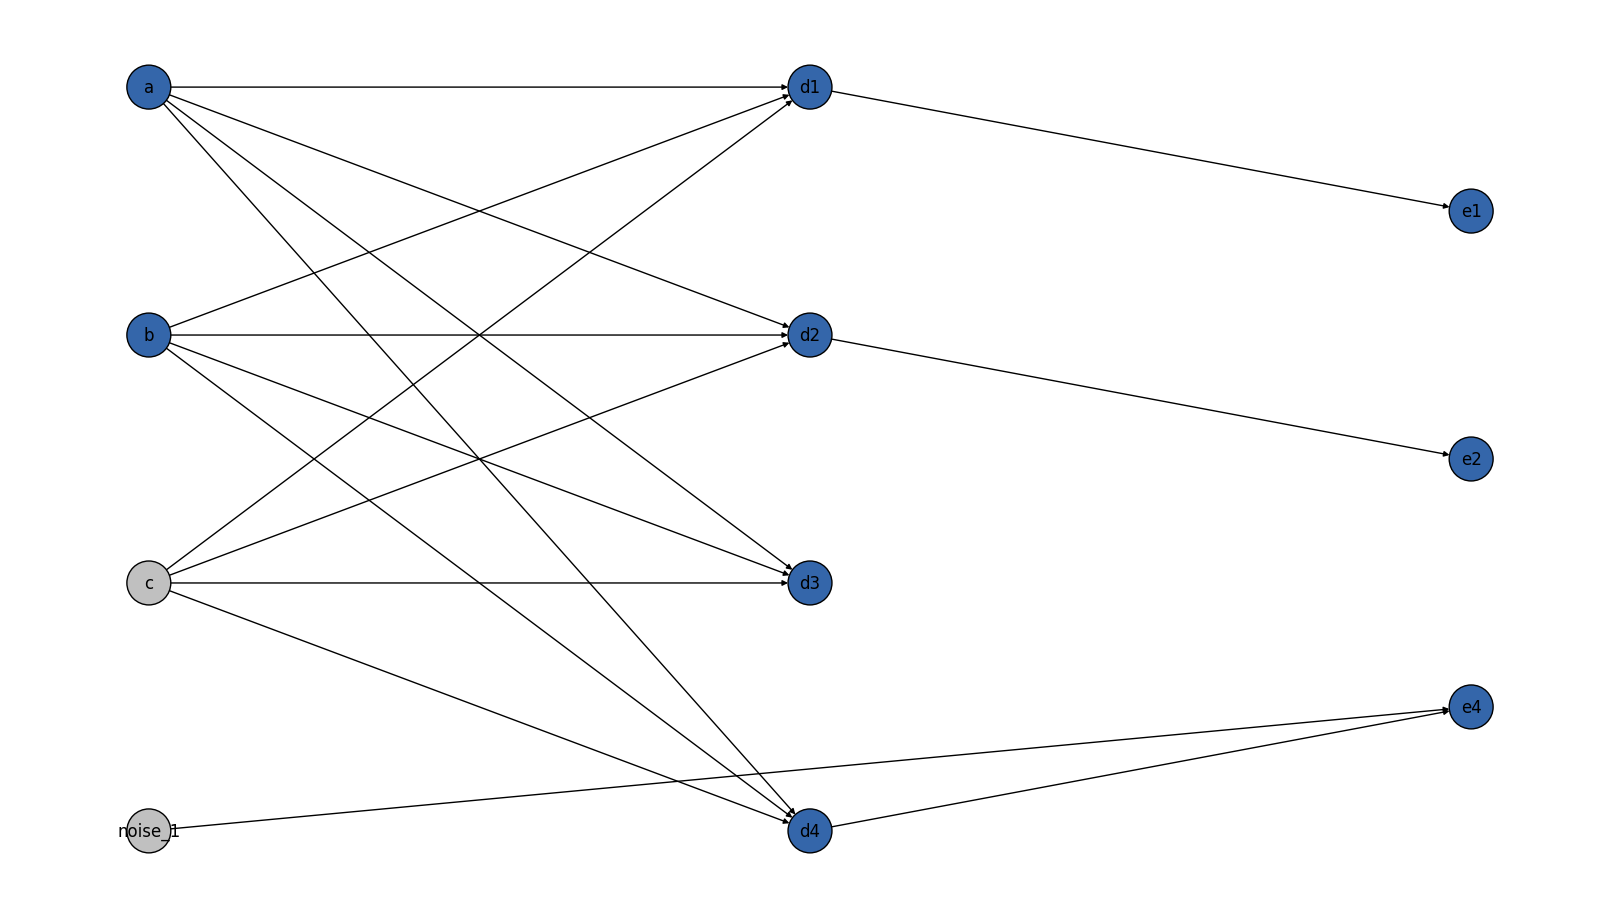

In [14]:
dg.visualize()